# Initialization

## Importing libs and setting plot style

In [14]:
import itertools
import multiprocessing as mp
import os
import random
import threading
import time
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from atpbar import atpbar, flush
from matplotlib import rc

In [2]:
# Setting plot style

sns.set()
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.0})

rc("text", usetex=True)

sns.set_style("ticks")
sns.set_style(
    "whitegrid",
    {
        "axes.edgecolor": "black",
        "axes.grid": True,
        "axes.axisbelow": True,
        "axes.labelcolor": ".15",
        "grid.color": "0.9",
        "grid.linestyle": "-",
        "xtick.direction": "in",
        "ytick.direction": "in",
        "xtick.bottom": True,
        "xtick.top": True,
        "ytick.left": True,
        "ytick.right": True,
        "font.family": ["sans-serif"],
        "font.sans-serif": ["Liberation Sans", "Bitstream Vera Sans", "sans-serif"],
    },
)

## Global variables

In [34]:
# folder with stored data
data_folder = "../../data"

# GFlowNet parameters
spin_list = [2.0]
iteration_list = [int(1e4) for i in range(0, 1)]
main_layer_hidden_nodes_list = [(30, 20) for i in range(0, 1)]
evaluation_batch_size_list = [int(1e6) for i in range(0, 1)]
training_batch_size_list = [int(1e3) for i in range(0, 1)]
generate_samples_every_training_samples_list = [int(1e6) for i in range(0, 1)]

model = "single_vertex_model"
branch1_hidden_nodes = ()
branch2_hidden_nodes = ()
activation_function = "swish"
exploration_rate = 0.5
training_fraction_from_back_traj = 0.0
learning_rate = 0.0005

# set optimal number of threads
optimal_number_of_threads = int(mp.cpu_count())
print(f"optimal number of threads: {optimal_number_of_threads}")

optimal number of threads: 12


# Angles

## Computation

In [5]:
# takes an intertwiner and returns the corresponding angle eigenvalue

def from_intertwiner_to_angle(matrix_element, spin):
    return (matrix_element * (matrix_element + 1) - 2 * spin * (spin + 1)) / (
        2 * spin * (spin + 1)
    )

In [6]:
def from_draws_to_angles(
    folder_prefix,
    spin,
    sample_name,
    dihedral_angle_path,
    n,
    name,
):
    for i in atpbar(range(n), name=name):
        time.sleep(0.0001)

    sample_path = f"{folder_prefix}/samples/{sample_name}"

    # load in memory the stored draws
    df = pd.read_csv(sample_path, low_memory=False)
    df.columns = df.columns.str.replace("intertwiner ", "node ", regex=True)

    # from intertwiners to angles
    df.iloc[:, :5] = df.iloc[:, :5].apply(from_intertwiner_to_angle, args=(spin,))

    ##########################################################
    # Computing exp values (avg)
    ##########################################################

    df_final = pd.concat([df.mean()], axis=1)
    df_final.columns = ["cosine angle avg"]

    angle_exp_values_path_batch = f"{dihedral_angle_path}/{name}"
    
    df_final.to_csv(angle_exp_values_path_batch, index=True)

In [7]:
# Converts multiple samples into dihedral angles.
# Store the result for each batch, then combines all batchs in another CSV file

def angles_compute(
    data_folder,
    model,
    spin,
    total_iterations,
    main_layer_hidden_nodes,
    evaluation_batch_size,
    generate_samples_every_training_samples,
    batch_size,
    activation_function="swish",
    exploration_rate=0.5,
    training_fraction_from_back_traj=0.0,
    learning_rate=0.0005,
    number_of_threads=optimal_number_of_threads,
):
    folder_prefix = Path(
        f"{data_folder}/",
        f"GFlowNet/{model}/j_{spin}/",
        f"main_layer_hid_nodes_{main_layer_hidden_nodes}/",
        f"exploration_rate_{exploration_rate}/learning_rate_{learning_rate}/activation_function_{activation_function}",
        f"n_iterations_{total_iterations}/evaluation_batch_size_{evaluation_batch_size}/batch_size_{batch_size}"
    )

    batch_sample_path_collection = []

    for i in range(total_iterations):
        trained_on_k_samples = (i + 1) * batch_size

        if trained_on_k_samples % generate_samples_every_training_samples == 0:
            sample_name = Path(
                f"epoch_{i + 1}"
                f"_after_learn_from_{trained_on_k_samples}"
                "_train_samples.csv",
            )

            if os.path.isfile(f"{folder_prefix}/samples/{sample_name}"):
                batch_sample_path_collection.append(sample_name)

            else:
                warnings.warn("Warning: the sample %s was not found" % (sample_name))

    batches_to_assemble = len(batch_sample_path_collection)

    if batches_to_assemble != 0:
        print(f"{batches_to_assemble} sample batches to process")

        dihedral_angle_path = f"{folder_prefix}/operators/angles"

        os.makedirs(f"{dihedral_angle_path}", exist_ok=True)

        print(
            f"\nComputing angles of {batches_to_assemble} sample batches for spin {spin}, using {number_of_threads} threads...\n"
        )

        threads = []

        for sample_name in batch_sample_path_collection:
            name = "angles_{}".format(sample_name)
            n = random.randint(number_of_threads, 10000)

            t = threading.Thread(
                target=from_draws_to_angles,
                args=(
                    folder_prefix,
                    spin,
                    sample_name,
                    dihedral_angle_path,
                    n,
                    name,
                ),
            )
            threads.append(t)
            t.start()

        # wait for the threads to complete
        for t in threads:
            t.join()

        flush()

        print(f"All samples in all batches have been processed")
        print(f"\nAssembling {batches_to_assemble} batches...")

        ##########################################################
        ### Assembling expectation values
        ##########################################################

        DF_list = [
            pd.read_csv(
                f"{dihedral_angle_path}/angles_{sample_name}",
                index_col=0,
                low_memory=False,
            )
            for sample_name in batch_sample_path_collection
        ]

        df_all_batches = pd.concat(
            DF_list[:], axis=1, keys=batch_sample_path_collection
        )

        df_all_batches.columns = df_all_batches.columns.droplevel(-1)
        df_all_batches.T
        df_all_batches.to_csv(
            f"{dihedral_angle_path}/batches_assembled_{batches_to_assemble}.csv",
            index=True,
        )

        print("Done")

    else:
        warnings.warn("Angles cannot be computed since there are no samples available")

In [8]:
for (
    spin,
    total_iterations,
    main_layer_hidden_nodes,
    evaluation_batch_size,
    training_batch_size,
    generate_samples_every_training_samples,
) in zip(
    spin_list,
    iteration_list,
    main_layer_hidden_nodes_list,
    evaluation_batch_size_list,
    training_batch_size_list,
    generate_samples_every_training_samples_list,
):
    angles_compute(
        data_folder,
        model,
        spin,
        total_iterations,
        main_layer_hidden_nodes,
        evaluation_batch_size,
        generate_samples_every_training_samples,
        training_batch_size,
        activation_function="swish",
        exploration_rate=0.5,
        training_fraction_from_back_traj=0.0,
        learning_rate=0.0005,
        number_of_threads=optimal_number_of_threads,
    )

10 sample batches to process

Computing exp. values of 10 sample batches, using 12 threads...



VBox()

All samples in all batches have been processed

Assembling 10 batches...
Done


## Plots

/home/frisus/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


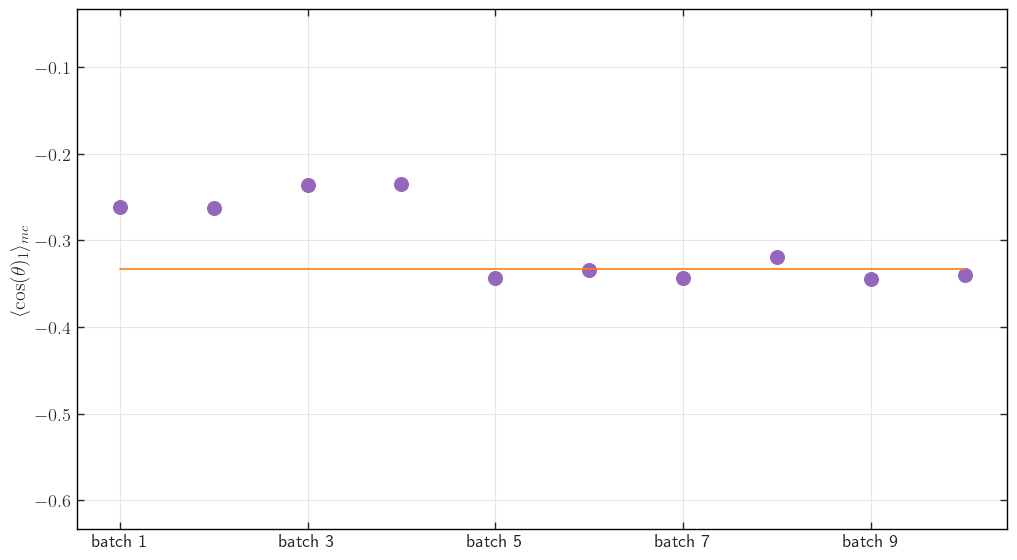

In [40]:
for (
    spin,
    total_iterations,
    main_layer_hidden_nodes,
    evaluation_batch_size,
    training_batch_size,
    generate_samples_every_training_samples,
) in zip(
    spin_list,
    iteration_list,
    main_layer_hidden_nodes_list,
    evaluation_batch_size_list,
    training_batch_size_list,
    generate_samples_every_training_samples_list,
):
    
    CSV_folder_path = Path(
    f"{data_folder}/",
    f"GFlowNet/{model}/j_{spin}/",
    f"main_layer_hid_nodes_{main_layer_hidden_nodes}/",
    f"exploration_rate_{exploration_rate}/learning_rate_{learning_rate}/activation_function_{activation_function}/",
    f"n_iterations_{total_iterations}/evaluation_batch_size_{evaluation_batch_size}/batch_size_{training_batch_size}/",
    f"operators/angles/"
    )
    
    parent_path = os.listdir(f"{CSV_folder_path}")
    
    batches_assembled = 0
    
    for file in parent_path:
        if file.startswith("batches_assembled"):
            batches_assembled = int ( ''.join(filter(str.isdigit, file) ) )
        
    df = pd.read_csv(
    f"{CSV_folder_path}/batches_assembled_{batches_assembled}.csv",
    low_memory=False,
    index_col=0,
    )
    
    renamed_columns = []
    
    for batch_id in range(batches_assembled):
        renamed_columns.append(f"batch {batch_id+1}")
        
    df.columns = renamed_columns   
    
    df = df.T

    #spin_list = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]
    df["batches"] = [i for i in range(0, batches_assembled)]
    df["reg_angles"] = [-0.33333 for i in range(0, batches_assembled)]
    
    ax = df.plot(
    x="batches",
    y="node 1",
    s=100,
    kind="scatter",
    grid="false",
    color="tab:purple",
    label="computed cosine angle value",
    figsize=(12, 6.75),
    legend=False,
    )
    df.plot(
    #x="spin",
    y="reg_angles",
    ax=ax,
    kind="line",
    color="tab:orange",
    linewidth=1.2,
    label="cosine angle regular tetrahedron",
    legend=False,
    )
    
    delta = 0.3 
    ax.set_ylim([-0.333 - delta, -0.3333 + delta])
    plt.ylabel(r"$\langle \cos (\theta)_1 \rangle_{mc}$")
    plt.xlabel(" ")

    # save the plot
    plot_path = Path(
    f"./plots/",
    f"GFlowNet/{model}/j_{spin}/",
    f"main_layer_hid_nodes_{main_layer_hidden_nodes}/",
    f"exploration_rate_{exploration_rate}/learning_rate_{learning_rate}/activation_function_{activation_function}/",
    f"n_iterations_{total_iterations}/evaluation_batch_size_{evaluation_batch_size}/batch_size_{training_batch_size}/",
    f"operators/angles/"
    )
    
    os.makedirs(plot_path, exist_ok=True)
    
    printfile = f"{plot_path}/batches_assembled_{batches_assembled}"
    plt.savefig(printfile + ".svg")
    # plt.savefig(printfile+'.png',dpi=300